In [1]:
import os
from os import listdir
from os.path import isfile, isdir, join, getsize

import pandas as pd
import re
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from mpl_toolkits.mplot3d import Axes3D


In [2]:
db_log_dir = join('..', 'data', 'exp_logs-parallelizaton_exp', 'logs')
out_dir = join('..', 'plots', 'log_analysis')

In [3]:
isdir(db_log_dir)

True

In [4]:
all_files = listdir(db_log_dir)

In [5]:
interesting_log_files = [x for x in listdir(db_log_dir) if getsize(join(db_log_dir, x)) > 0]

In [6]:
interesting_log_files

['DyLDO-core-type-parallel_2-test-2_batch_11.log',
 'DyLDO-core-schemex-parallel_4-test-1_batch_14.log',
 'DyLDO-core-attribute-parallel_8-test-2_batch_22.log',
 'DyLDO-core-type-parallel_4-test-2_batch_17.log',
 'DyLDO-core-type-parallel_2-test-2_batch_38.log',
 'DyLDO-core-type-parallel_8-test-2_batch_31.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_4.log',
 'DyLDO-core-schemex-parallel_8-test-1_batch_38.log',
 'DyLDO-core-type-parallel_8-test-2_batch_20.log',
 'DyLDO-core-attribute-parallel_4-test-2_batch_40.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_25.log',
 'DyLDO-core-type-parallel_8-test-2_batch_12.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_2.log',
 'DyLDO-core-type-parallel_4-test-2_batch_31.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_18.log',
 'DyLDO-core-type-parallel_4-test-2_batch_2.log',
 'DyLDO-core-attribute-parallel_16-test-2_batch_16.log',
 'DyLDO-core-schemex-parallel_2-test-1_batch_5.log',
 'DyLDO-core-type-parallel_2-test-2_b

In [7]:
stats = {}

df = pd.DataFrame(columns=['Dataset', 'Version', 'Model', 'Cores', 'Conflicts'])
for file in interesting_log_files:
    # DyLDO-core-attribute-parallel_16-test-2_batch_43
    z = re.match('(.*)(-.*)(-parallel)(_[0-9]+)(-test-[0-9])(_batch)?_([0-9]+)$', file.replace('.log', ''))
    # ('DyLDO-core', '-attribute', '-parallel', '_16', '-test-2', '_batch', '43')
    if len(z.groups()) != 7:
        display(z.groups())
        print(file)
    stats[file.replace('.log', '')] = {}
    conflicts = 0
    with open(join(db_log_dir, file), 'r') as log_file:
        lines = log_file.readlines()
        for line in lines:
            vs_id = line.split('[UPDATES]')[-1].replace('\n', '').strip()
            if vs_id in stats[file.replace('.log', '')]:
                stats[file.replace('.log', '')][vs_id] += 1
            else:
                stats[file.replace('.log', '')][vs_id] = 1
            conflicts += 1
        df = df.append({'Dataset': z.groups()[0], 
                        'Version': z.groups()[6], 
                        'Model': z.groups()[1][1::], 
                        'Cores': z.groups()[3][1::], 
                        'Conflicts': conflicts },ignore_index=True)

df['Cores'] = df['Cores'].astype('int')    

In [8]:
def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    #display(Y)
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    #print(np.min(values[0]))
    """
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    #print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    #display(temp)
    lvls, colors = zip(*temp)
    #display(lvls)
    #display(colors)
    
    # TODO: 40 is not displayed properly
    if lvls[2] == 40:
        lvls = list(lvls)
        lvls[2] = 39
    #lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)
    """
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.invert_xaxis()
    ax.view_init(35, 25)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    #ax.set_ylim([-y_offset, len(y)+y_offset])
    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Merge Conflicts", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight', dpi=300)
        
    plt.show()


,Dataset,Version,Model,Cores,Conflicts
Version,,,,,
0,DyLDO-core,0,type,16,11242
0,DyLDO-core,0,attribute,4,117
0,DyLDO-core,0,attribute,8,311
0,DyLDO-core,0,schemex,8,147
0,DyLDO-core,0,type,4,1150
...,...,...,...,...,...
50,DyLDO-core,50,type,4,961
50,DyLDO-core,50,attribute,8,354
50,DyLDO-core,50,schemex,4,67


Model: type
Cores: 2
Cores: 4
Cores: 8
Cores: 16
[2, 4, 8, 16]


[array([408, 369, 328, 403, 339, 310, 351, 339, 343, 438, 425, 363, 517,
        417, 308, 446, 440, 438, 339, 313, 569, 399, 488, 535, 267, 671,
        529, 368, 513, 483, 685, 671, 619, 501, 647, 528, 504, 456, 476,
        517, 339, 477, 344, 226, 476, 276, 323, 350, 344, 291]),
 array([1150,  878, 1094, 1092,  959,  745,  994, 1024, 1163, 1027, 1295,
        1108, 1253, 1005,  894, 1158, 1146, 1145,  927,  987, 1345, 1227,
        1328, 1373, 1016, 1634, 1671, 1711, 1633, 1799, 1862, 1814, 1699,
        1609, 1613, 1694, 1600, 1275, 1407, 1420, 1102, 1293, 1093, 1121,
        1084,  798,  976,  982,  977,  961]),
 array([3691, 2838, 3722, 3634, 3017, 2299, 3209, 3232, 3534, 3374, 4468,
        3437, 4098, 3503, 2926, 3494, 3742, 3651, 2989, 3220, 4809, 3871,
        4612, 4421, 3303, 5653, 5579, 5684, 5753, 6322, 6204, 6183, 5730,
        5697, 5409, 5604, 5625, 4260, 4763, 4667, 3680, 3974, 3679, 3942,
        3559, 2387, 2963, 2942, 3032, 2980]),
 array([11242,  8607, 10871, 111

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


(4, 50)

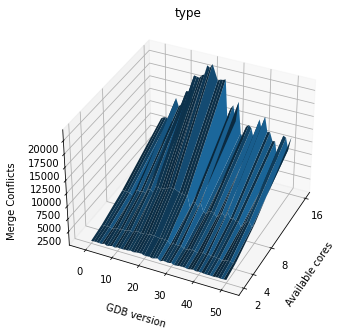

Model: attribute
Cores: 2
Cores: 4
Cores: 8
Cores: 16
[2, 4, 8, 16]


[array([16, 24, 13, 20, 52,  9, 20, 17, 30, 32, 22, 47, 26, 28, 20, 18, 24,
        15, 21, 20, 27, 15, 45, 31, 20, 54, 97, 17, 60, 53, 33, 29, 22, 36,
        85, 39, 48, 30, 16, 22, 16, 16, 22, 58, 13, 24, 27, 25, 28, 17]),
 array([117,  94,  94, 110, 115,  99,  89,  78,  95, 125, 153, 127, 142,
        117, 124, 100, 107, 107, 111,  90, 151, 127, 144, 148, 132, 219,
        213, 214, 215, 204, 253, 217, 235, 230, 244, 223, 232, 196, 171,
        163, 165, 147, 161, 171, 117, 133, 126, 129, 139, 118]),
 array([311, 341, 336, 330, 354, 297, 265, 259, 291, 370, 419, 430, 366,
        393, 346, 296, 276, 277, 310, 250, 373, 322, 435, 412, 412, 638,
        607, 571, 581, 671, 640, 602, 568, 603, 590, 580, 606, 522, 480,
        458, 477, 405, 527, 449, 350, 350, 333, 346, 331, 354]),
 array([ 586,  580,  569,  606,  614,  628,  530,  559,  619,  793,  832,
         783,  805,  711,  778,  703,  587,  616,  543,  451,  697,  468,
         961,  623,  642,  912,  965,  940, 1343,  871,  9

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


(4, 50)

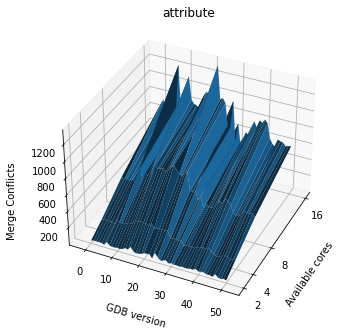

Model: schemex
Cores: 2
Cores: 4
skip due to shape missmatch (experiement incomplete?)
Cores: 8
skip due to shape missmatch (experiement incomplete?)
Cores: 16
skip due to shape missmatch (experiement incomplete?)
[2]


[array([12,  6,  8,  4,  3,  6,  7, 20,  8, 13,  9,  7,  9,  9,  9,  9,  9,
         8,  5])]

[50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


(1, 19)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

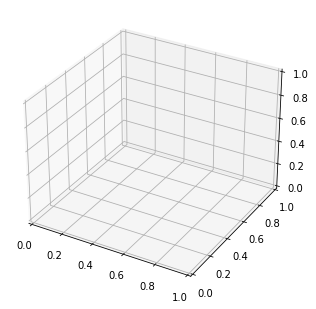

In [9]:
a_frame = df #df[df['Cores'] == cores]
a_frame.index = a_frame['Version'].astype(int)
a_frame.sort_index(inplace=True)
display(a_frame)
plot_frame = pd.DataFrame(columns=df['Model'].unique())
for model in df['Model'].unique():
    print('Model: %s' % model)
    a_frame = df[df['Model'] == model]
    #x = list(a_frame['Cores'].unique())
    x = []
    #display(len(x))
    values = []
    all_cores = list(a_frame['Cores'].unique())
    all_cores.sort()
    for core in all_cores:
        print('Cores: %s' % core)
        t_val_frame = a_frame[a_frame['Cores'] == core]
        #display(t_val_frame)
        t_vals = np.array(a_frame[a_frame['Cores'] == core]['Conflicts'].astype(int))
        if len(values) > 0 and len(t_vals) != len(values[0]):
            print('skip due to shape missmatch (experiement incomplete?)')
        else:
            values.append(t_vals)
            x.append(core)
            #display(t_vals)
    #x.reverse()
    print(x)
    #values.reverse()
    display(values)
    y = list(set(a_frame['Version'].astype(int)))
    y.reverse()
    print(y)
    display(np.array(values).shape)
    #values = np.array(df[['Cores', 'Conflicts']])
    my_3d_plot(x, y, values, model, z_lim=None, save_dir=out_dir)
    
    

Text(0.5, 1.0, 'type')

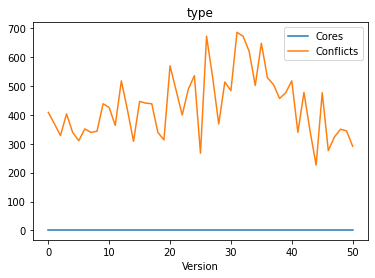

In [10]:
a_frame = df[df['Cores'] == 2]
ax = a_frame[a_frame['Model'] == 'type'].plot()
ax.set_title('type')

<AxesSubplot:xlabel='Version'>

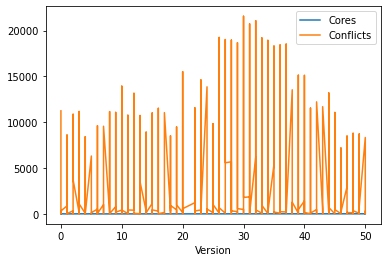

In [11]:
df.plot()

In [12]:
import re
asd = 'DyLDO-core-attribute-parallel_2-test-2_batch_0'

z = re.match('(.*)(-.*)(-parallel)(_[0-9]+)(-test-[0-9])(_batch)?_([0-9]+)$', asd)
z

<re.Match object; span=(0, 46), match='DyLDO-core-attribute-parallel_2-test-2_batch_0'>

In [13]:
z.groups()

('DyLDO-core', '-attribute', '-parallel', '_2', '-test-2', '_batch', '0')

In [14]:
z.groups()[1][1::]

'attribute'

In [15]:
# hot vertex summaries

display(stats)

{'DyLDO-core-type-parallel_2-test-2_batch_11': {'48': 360,
  '-2030505161': 2,
  '564491453': 1},
 'DyLDO-core-schemex-parallel_4-test-1_batch_14': {'705015663': 1,
  '1594849491': 1,
  '-1088303476': 9,
  '-1179040837': 1,
  '-1353725903': 3,
  '-1805512467': 9,
  '-1414600713': 2,
  '436382022': 5,
  '1707245920': 1,
  '-1536466884': 1,
  '1902789480': 1,
  '-1816604523': 3,
  '1399805594': 1,
  '-986329313': 3,
  '-982548492': 1,
  '1050245056': 3,
  '1639832908': 1,
  '-1014853334': 1,
  '-1189176794': 1,
  '623222006': 2,
  '-1383911043': 2,
  '1008988421': 1,
  '-1724669533': 1},
 'DyLDO-core-attribute-parallel_8-test-2_batch_22': {'-121913705': 16,
  '1383854819': 45,
  '-237374872': 39,
  '1535074497': 1,
  '1609285120': 2,
  '1109828132': 1,
  '1833646158': 5,
  '271392804': 13,
  '1413160744': 1,
  '1072875714': 1,
  '-1805512467': 42,
  '377543283': 3,
  '-212013139': 5,
  '1487371367': 1,
  '681013538': 3,
  '987914379': 1,
  '323493703': 1,
  '-1215354179': 4,
  '-10883034

In [16]:
display(sum(list(stats['DyLDO-core-type-parallel_8-test-2_batch_20'].values())))

4809

In [17]:
stats['DyLDO-core-type-parallel_8-test-2_batch_20']['48']/sum(list(stats['DyLDO-core-type-parallel_8-test-2_batch_20'].values()))

0.9787897691827823

In [64]:
filter_cores = "parallel_16"

no_type_frame = pd.DataFrame(columns=['iteration', 'conflicts'])

no_types = []
no_properties = []
hot_summaries = {}
for key in stats.keys():
    if filter_cores and not (filter_cores in key):
        continue
    if 'type' in key:
        summary = 'Type Collection'
    if 'attribute' in key:
        summary = 'Attribute Collection'
    if 'schemex' in key:
        summary = 'SchemEX'
        
    if '48' in stats[key]:
        if 'type' in key:
            snapshot = key.split('batch_')[1]
            no_type_frame = no_type_frame.append({'iteration': int(snapshot), 'conflicts': stats[key]['48']}, ignore_index=True)
            # print('Type Collection: %s (%s)' % (stats[key]['48'], snapshot))
        else:
            
            print('[48] Other Collection: %s ' % key)
        no_types.append(stats[key]['48'] / sum(list(stats[key].values())))

    if '-1805512467' in stats[key]:
        if 'attribute' in key:
            pass
        else:
            print('[-1805512467] Other Collection: %s ' % key)
        no_properties.append(stats[key]['-1805512467'] / sum(list(stats[key].values())))
        
        #data = list(stats[key].values())
    hot_id = max(stats[key], key=stats[key].get)
    hot_val = max(stats[key].values())
    
    if summary not in hot_summaries:
        hot_summaries[summary] = {}
    
    if hot_id in hot_summaries[summary]:
        hot_summaries[summary][hot_id].append(hot_val)
    else:
        hot_summaries[summary][hot_id] = [hot_val]
    #hot_summaries.append([, max(stats[key].values())])
        #plt.hist(data, bins=len(data), alpha=0.5)
        #plt.show()
        #break
   
import statistics as st
print('___Update conflict share for 48 (no types)___')
print('Min: {:7.2f} %'.format(min(no_types) * 100))
print('Max: {:7.2f} %'.format(max(no_types) * 100))
print('Mean: {:6.2f} %'.format(st.mean(no_types)*100))
print('Std: {:7.2f} %'.format(st.stdev(no_types)*100))
print()
print('___Update conflict share for -1805512467 (no properties)___')
print('Min: {:7.2f} %'.format(min(no_properties) * 100))
print('Max: {:7.2f} %'.format(max(no_properties) * 100))
print('Mean: {:6.2f} %'.format(st.mean(no_properties)*100))
print('Std: {:7.2f} %'.format(st.stdev(no_properties)*100))
#display(hot_summaries)
print('_________')

other_than_type = []
for sum_key in hot_summaries.keys():
    for key in hot_summaries[sum_key].keys():
        print('[{:20}] <{:11}>: {:7,} conflicts distributed over {:3,} different runs'.format(sum_key, key, sum(hot_summaries[sum_key][key]), len(hot_summaries[sum_key][key])))
        if sum_key != 'Type Collection':
            other_than_type.append((sum(hot_summaries[sum_key][key])/ len(hot_summaries[sum_key][key])))
        
        
no_type_frame = no_type_frame.set_index('iteration')

[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_32 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_4 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_36 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_35 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_45 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_9 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_31 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_47 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_11 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_29 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_39 
[-1805512467] Other Collection: DyLDO-core-schemex-parallel_16-test-1_batch_8 
[-1805512467] Other Collection: DyLDO-core-

hot_summaries

* 48: no types
* -1805512467: no properties

In [57]:
#no_type_frame.sort_values(by='iteration')
no_type_frame.sort_index(inplace = True)
no_type_frame

,conflicts
iteration,
0,11127
1,8487
2,10760
3,11045
4,8292
5,6161
6,9528
7,9483
8,11018


<AxesSubplot:xlabel='iteration'>

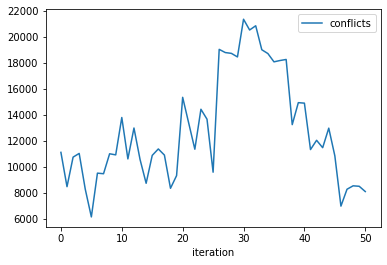

In [58]:
no_type_frame.plot()

In [61]:
print('[Type Coll] Mean payload merge conflicts for no types: %s' % no_type_frame['conflicts'].mean())
print('[Type Coll] std payload merge conflicts for no types: %s' % no_type_frame['conflicts'].std())
print('[Type Coll] max payload merge conflicts for no types: %s' % no_type_frame['conflicts'].max())

[Type Coll] Mean payload merge conflicts for no types: 12828.12
[Type Coll] std payload merge conflicts for no types: 4148.713902708961
[Type Coll] max payload merge conflicts for no types: 21367


In [67]:
st.mean(other_than_type)

122.90425925925926

In [68]:
st.stdev(other_than_type)

81.41805327507817